In [210]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
from scipy import stats
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output
from itertools import product
%matplotlib inline

from scipy.spatial.distance import pdist

from sklearn.cluster import DBSCAN, SpectralClustering, Birch, KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF, PCA
from scipy.stats import kde

plt.rcParams['figure.figsize'] = 21,6
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [68]:
def evaluate_clustering(clusters, partition):
    n = len(clusters)

    counter_dict = {
        "SS":0,
        "SD":0,
        "DS":0,
        "DD":0
    }

    for i in range(n):
        for j in range(i+1, n):
            if clusters[i]==clusters[j] and partition[i]==partition[j]:
                counter_dict["SS"]+=1
            elif clusters[i]==clusters[j] and partition[i]!=partition[j]:
                counter_dict["SD"]+=1    
            elif clusters[i]!=clusters[j] and partition[i]==partition[j]:
                counter_dict["DS"]+=1    
            elif clusters[i]!=clusters[j] and partition[i]!=partition[j]:
                counter_dict["DD"]+=1
    
    return counter_dict

def rand_stat(clusters, partition):
    cd = evaluate_clustering(clusters, partition)
    a,b,c,d = cd["SS"],cd["SD"],cd["DS"],cd["DD"]
    return (a+d)/(a+b+c+d)

def jacc_coef(clusters, partition):
    cd = evaluate_clustering(clusters, partition)
    a,b,c,d = cd["SS"],cd["SD"],cd["DS"],cd["DD"]
    return a/(a+b+c)

def fm_index(clusters, partition):
    cd = evaluate_clustering(clusters, partition)
    a,b,c,d = cd["SS"],cd["SD"],cd["DS"],cd["DD"]
    return np.sqrt(a**2/((a+b)*(a+c)))

def gamma_statistic(X,Y):
    N = X.shape[0]
    M = N*(N-1)/2
    return np.sum(np.tril(X*Y,-1))/M

def generate_sample(x_mean, y_mean, x_std=0.2, y_std=0.2, size=100):
    return np.c_[np.random.normal(loc=x_mean,scale=x_std,size=size),np.random.normal(loc=y_mean,scale=y_std,size=size)]

def proximity_matrix(X):
    n = X.shape[0]
    return np.array(list(map(lambda pair: np.linalg.norm(pair[0]-pair[1]), product(X,X)))).reshape(n,n)

def cluster_matrix(clusters):
    n = len(clusters)
    return np.array(list(map(lambda pair: int(pair[0]!=pair[1]), product(clusters,clusters)))).reshape(n,n)

def test(labels, data):
#     method.fit(data)
    
    return (metrics.davies_bouldin_score(data, labels),
            metrics.silhouette_score(data, labels),
            gamma_statistic(metrics.pairwise_distances(data),cluster_matrix(labels)))

def how_many_clusters(method, data):
    results = {
        "db":[],
        "sh":[],
        "gamma":[]
    }
    for k in range(2, 20):
        m = method(n_clusters = k)
        m.fit(data)
        
        t = test(m.labels_, data)
        
        results['db'].append(t[0])
        results['sh'].append(t[1])
        results['gamma'].append(t[2])
    return results

In [126]:
data = pd.read_csv('transform.csv')
data_for_clustering = data.drop(['Wiek', 'Płeć', 'id_response'], axis=1)

# Cel analizy skupień

Na podstawie danych chcielibyśmy stwierdzić, czy po znalezieniu naturalnych skupień za pomocą algorytmów klastrujących otrzymamy grupy znacząco różniące się od siebie rozkładem płci i wieku. 



# Postać danych

In [127]:
data.head()

,Wiek,Płeć,id_response,cechynieodzowne - zabawki vs książka wartosc,cechynieodzowne - zabawki vs książka rozstep,informacyjnosc - ssak vs Polak wartosc,informacyjnosc - ssak vs Polak rozstep,istota - Pies vs butelka wartosc,istota - Pies vs butelka rozstep,jednorodnosc - kamienie szlachetne vs krzesła wartosc,jednorodnosc - kamienie szlachetne vs krzesła rozstep,nieodwracalnosc - zwierzęta vs uczeń wartosc,nieodwracalnosc - zwierzęta vs uczeń rozstep,odrebnosc - drewno vs miękkie wartosc,odrebnosc - drewno vs miękkie rozstep,stabilnosc - owoce vs pieniądze wartosc,stabilnosc - owoce vs pieniądze rozstep
0,23,1,41,4.75,7,8.00,3,10.00,0,7.75,4,4.00,6,6.25,9,1.50,6
1,20,0,42,4.00,5,3.00,3,6.75,2,6.50,5,6.50,4,6.00,4,6.75,1
2,38,1,67,7.25,8,4.25,3,5.00,0,9.50,2,6.25,10,9.50,2,5.25,8
3,17,0,43,4.75,5,6.00,3,5.25,8,5.75,3,5.50,4,7.00,3,6.25,4
4,17,0,45,4.25,9,5.75,6,7.50,10,4.25,6,6.00,8,5.25,7,5.75,10


# Postać danych do analizy

In [128]:
data_for_clustering.head()

,cechynieodzowne - zabawki vs książka wartosc,cechynieodzowne - zabawki vs książka rozstep,informacyjnosc - ssak vs Polak wartosc,informacyjnosc - ssak vs Polak rozstep,istota - Pies vs butelka wartosc,istota - Pies vs butelka rozstep,jednorodnosc - kamienie szlachetne vs krzesła wartosc,jednorodnosc - kamienie szlachetne vs krzesła rozstep,nieodwracalnosc - zwierzęta vs uczeń wartosc,nieodwracalnosc - zwierzęta vs uczeń rozstep,odrebnosc - drewno vs miękkie wartosc,odrebnosc - drewno vs miękkie rozstep,stabilnosc - owoce vs pieniądze wartosc,stabilnosc - owoce vs pieniądze rozstep
0,4.75,7,8.00,3,10.00,0,7.75,4,4.00,6,6.25,9,1.50,6
1,4.00,5,3.00,3,6.75,2,6.50,5,6.50,4,6.00,4,6.75,1
2,7.25,8,4.25,3,5.00,0,9.50,2,6.25,10,9.50,2,5.25,8
3,4.75,5,6.00,3,5.25,8,5.75,3,5.50,4,7.00,3,6.25,4
4,4.25,9,5.75,6,7.50,10,4.25,6,6.00,8,5.25,7,5.75,10


# Jak wybrać liczbę klastrów

1. minimalizacja indeksu Daviesa-Bouldina

2. maksymalizacja silhouette

3. minimalizacja Hubert's $\Gamma$ dla odległości między punktami wewnątrz klastrów

In [129]:
audit_kmean = how_many_clusters(KMeans, data_for_clustering)
audit_spectral = how_many_clusters(SpectralClustering, data_for_clustering)
audit_birch = how_many_clusters(Birch, data_for_clustering)

# Kmeans clustering

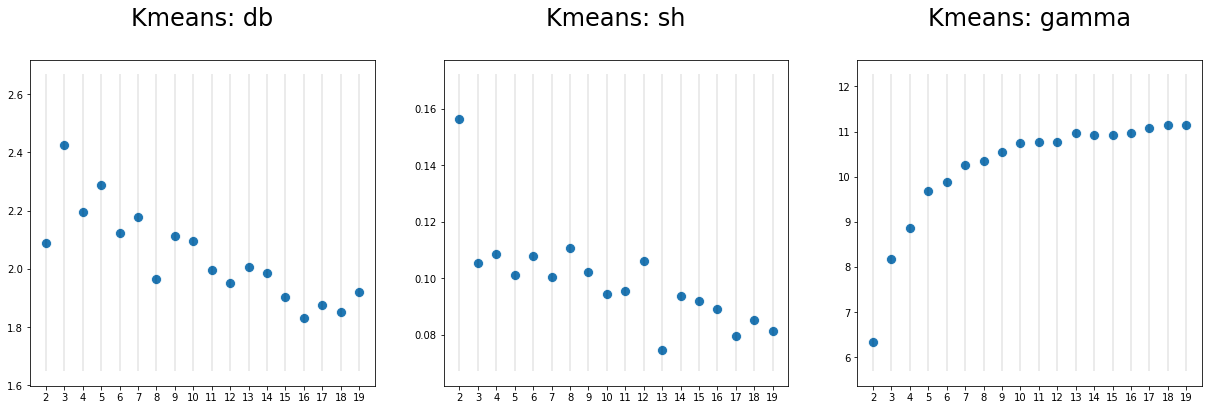

In [130]:
fig = plt.figure
for i, key in enumerate(audit_kmean.keys()):
    plt.subplot(1,3,i+1)
    sns.scatterplot(np.arange(2,20), audit_kmean[key], s=100)
    plt.xticks(np.arange(2,20))
    plt.vlines(np.arange(2,20),np.min(audit_kmean[key])*0.9,np.max(audit_kmean[key])*1.1, alpha = 0.1)
    plt.title(f'Kmeans: {key}\n', size=24)
plt.show()

# Spectral clustering

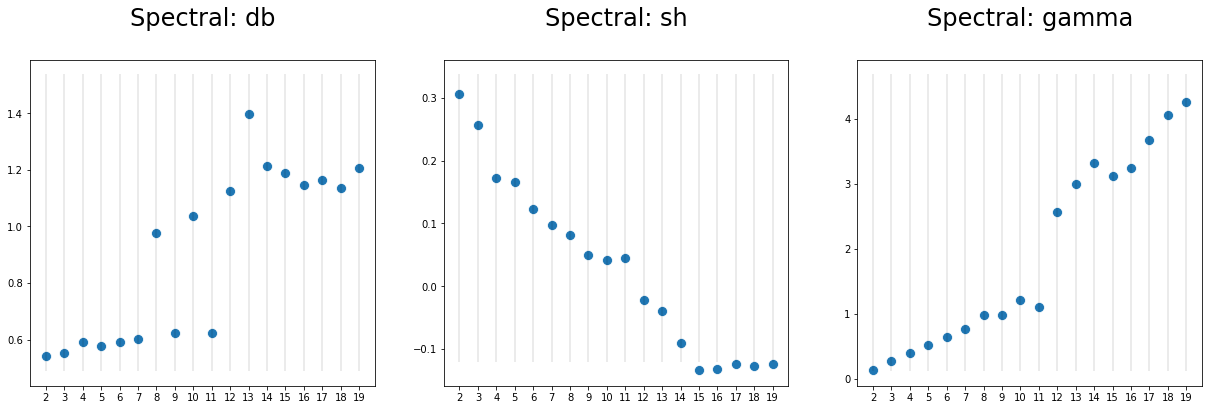

In [131]:
fig = plt.figure()
for i, key in enumerate(audit_spectral.keys()):
    plt.subplot(1,3,i+1)
    sns.scatterplot(np.arange(2,20), audit_spectral[key], s=100)
    plt.xticks(np.arange(2,20))
    plt.vlines(np.arange(2,20),np.min(audit_spectral[key])*0.9,np.max(audit_spectral[key])*1.1, alpha = 0.1)
    plt.title(f'Spectral: {key}\n', size=24)
plt.show()

# Birch clustering

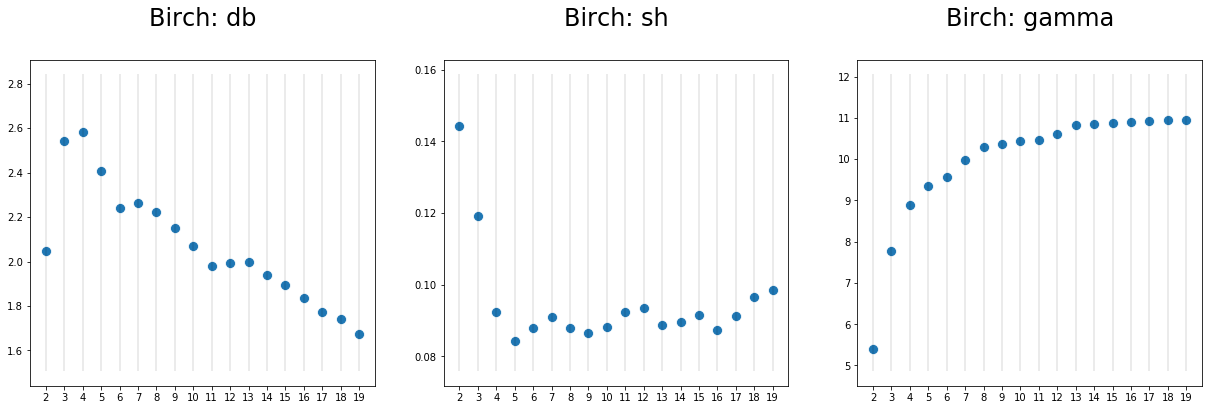

In [132]:
fig = plt.figure()
for i, key in enumerate(audit_birch.keys()):
    plt.subplot(1,3,i+1)
    sns.scatterplot(np.arange(2,20), audit_birch[key], s=100)
    plt.xticks(np.arange(2,20))
    plt.vlines(np.arange(2,20),np.min(audit_birch[key])*0.9,np.max(audit_birch[key])*1.1, alpha = 0.1)
    plt.title(f'Birch: {key}\n', size=24)
plt.show()

In [133]:
tsne = TSNE()
tsne.fit(data_for_clustering)

pca = PCA(n_components=2)
pca.fit(data_for_clustering)

nmf = NMF()
nmf.fit(data_for_clustering)

pass

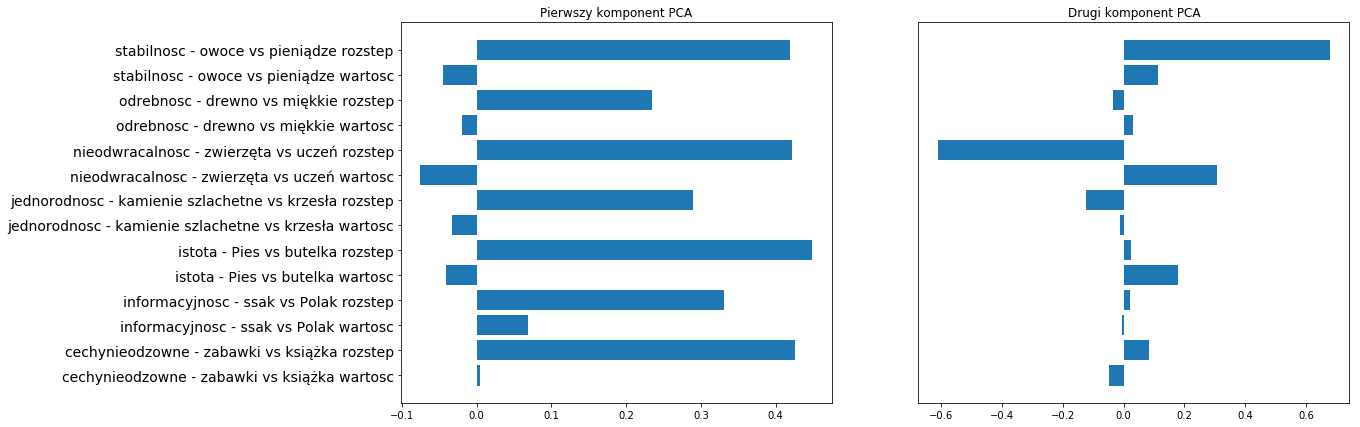

In [134]:
plt.figure(figsize = (17,7))
plt.subplot(1,2,1)
plt.title('Pierwszy komponent PCA')
plt.yticks(size=14)
plt.barh(data_for_clustering.columns, pca.components_[0])
plt.subplot(1,2,2)
plt.title('Drugi komponent PCA')
plt.barh(data_for_clustering.columns, pca.components_[1])
plt.yticks([])
plt.show()

In [135]:
n_clusters = 2

kmean = KMeans(n_clusters=n_clusters)
kmean.fit(data_for_clustering)

spec = SpectralClustering(n_clusters=n_clusters)
spec.fit(data_for_clustering)

birch = Birch(n_clusters=n_clusters)
birch.fit(data_for_clustering)

pass

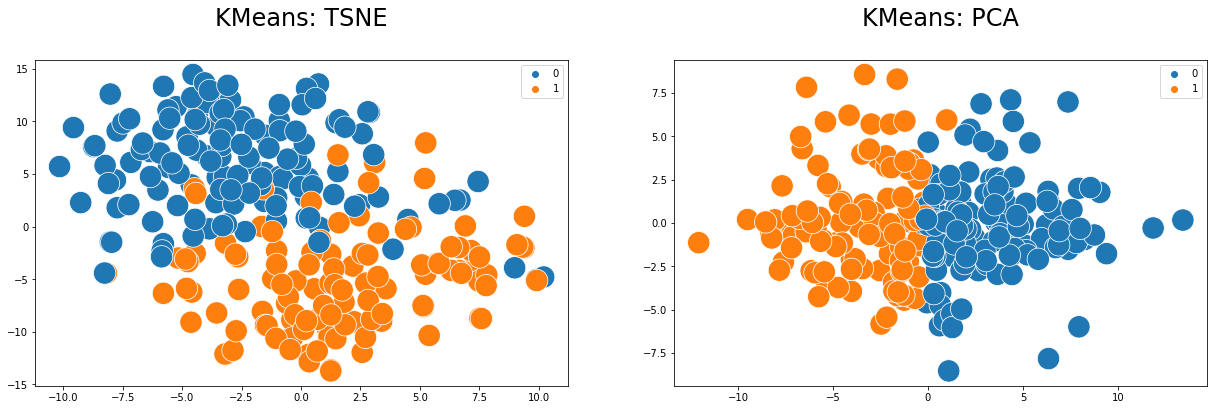

In [136]:
labels = kmean.labels_

plt.subplot(1,2,1)
sns.scatterplot(*tsne.embedding_.T, hue = labels, s=500)
plt.title('KMeans: TSNE\n', size=24)

plt.subplot(1,2,2)
sns.scatterplot(*pca.transform(data_for_clustering).T, hue = labels, s=500)
plt.title('KMeans: PCA\n', size=24)
plt.show()

# xxx = nmf.transform(data_for_clustering)
# sns.scatterplot(xxx[:,0], xxx[:,1], hue = labels, s=1000)
# plt.show()

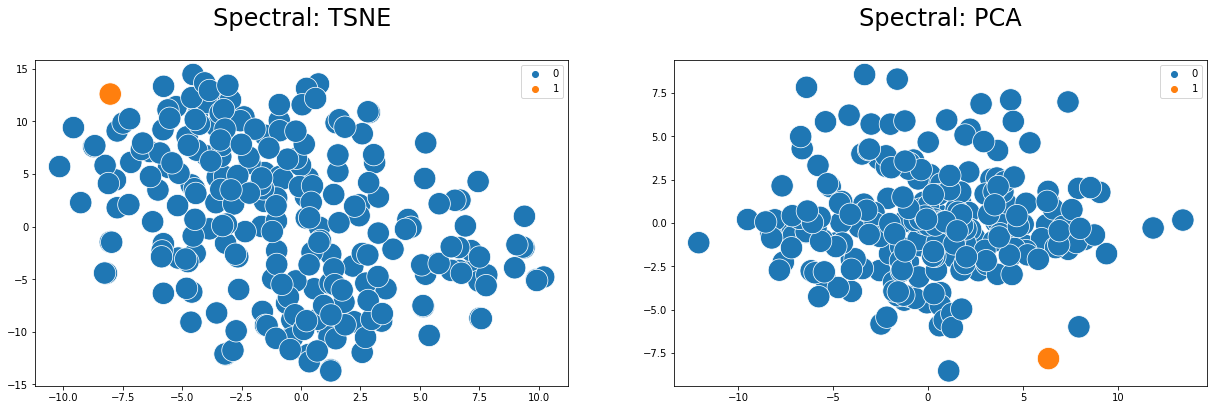

In [137]:
labels = spec.labels_

plt.subplot(1,2,1)
sns.scatterplot(*tsne.embedding_.T, hue = labels, s=500)
plt.title('Spectral: TSNE\n', size=24)

plt.subplot(1,2,2)
sns.scatterplot(*pca.transform(data_for_clustering).T, hue = labels, s=500)
plt.title('Spectral: PCA\n', size=24)
plt.show()

# xxx = nmf.transform(data_for_clustering)
# sns.scatterplot(xxx[:,0], xxx[:,1], hue = labels, s=1000)
# plt.show()

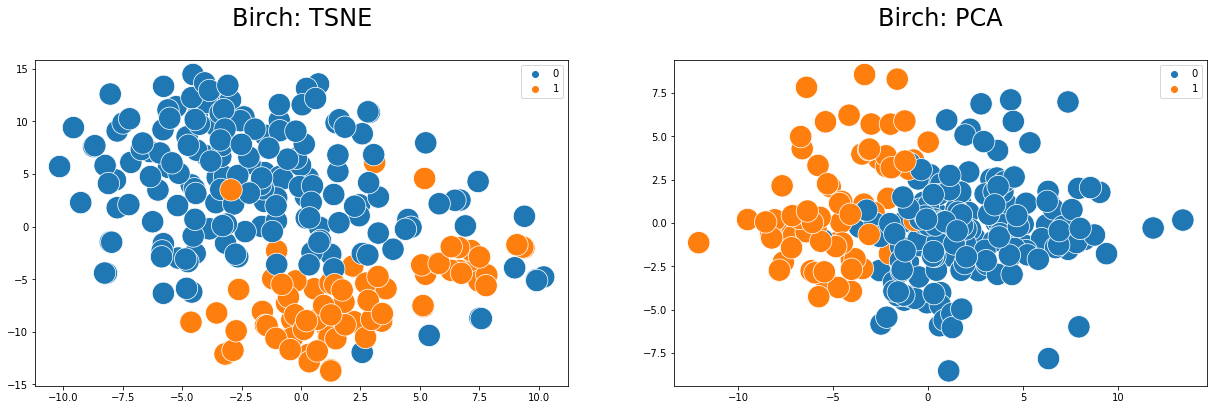

In [138]:
labels = birch.labels_

plt.subplot(1,2,1)
sns.scatterplot(*tsne.embedding_.T, hue = labels, s=500)
plt.title('Birch: TSNE\n', size=24)

plt.subplot(1,2,2)
sns.scatterplot(*pca.transform(data_for_clustering).T, hue = labels, s=500)
plt.title('Birch: PCA\n', size=24)
plt.show()

# xxx = nmf.transform(data_for_clustering)
# sns.scatterplot(xxx[:,0], xxx[:,1], hue = labels, s=1000)
# plt.show()

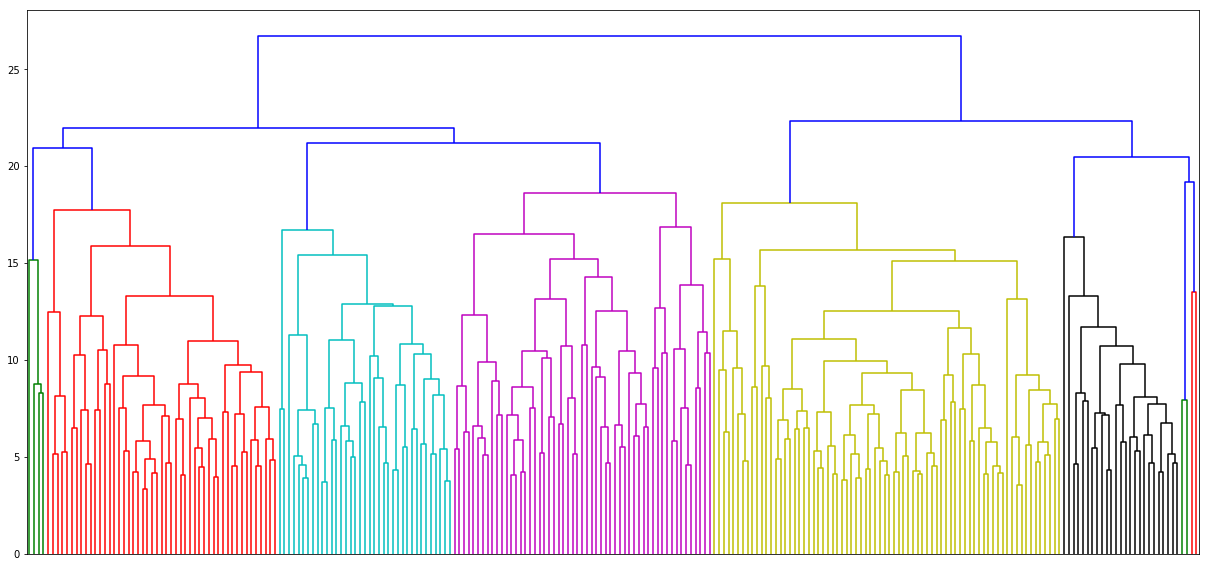

In [154]:
plt.figure(figsize=(21,10))
link = linkage(pdist(data_for_clustering), method='complete')
dendrogram(link, )
plt.xticks([])
plt.show()

# Wyniki po standaryzacji

In [140]:
stdsc = StandardScaler()
data_for_clustering_std = stdsc.fit_transform(data_for_clustering)
audit_kmean = how_many_clusters(KMeans, data_for_clustering_std)
audit_spectral = how_many_clusters(SpectralClustering, data_for_clustering_std)
audit_birch = how_many_clusters(Birch, data_for_clustering_std)

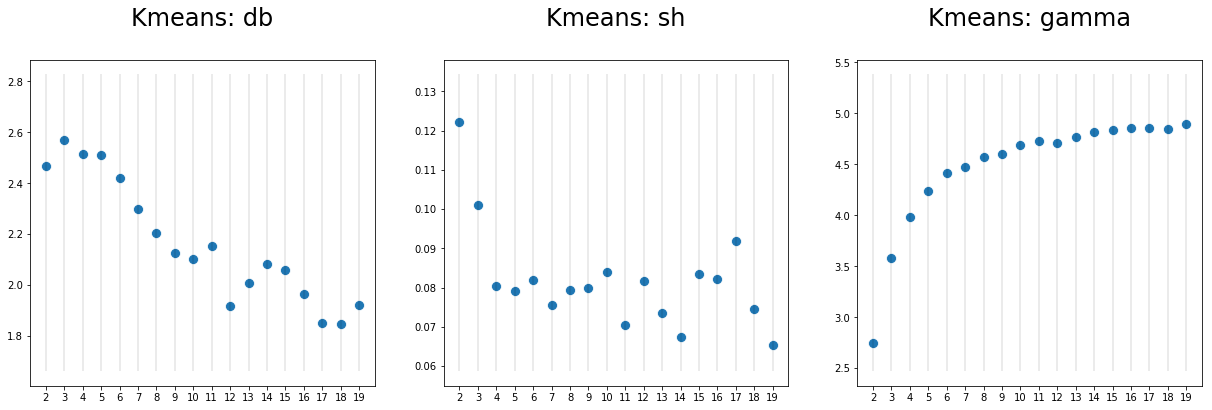

In [141]:
fig = plt.figure
for i, key in enumerate(audit_kmean.keys()):
    plt.subplot(1,3,i+1)
    sns.scatterplot(np.arange(2,20), audit_kmean[key], s=100)
    plt.xticks(np.arange(2,20))
    plt.vlines(np.arange(2,20),np.min(audit_kmean[key])*0.9,np.max(audit_kmean[key])*1.1, alpha = 0.1)
    plt.title(f'Kmeans: {key}\n', size=24)
plt.show()

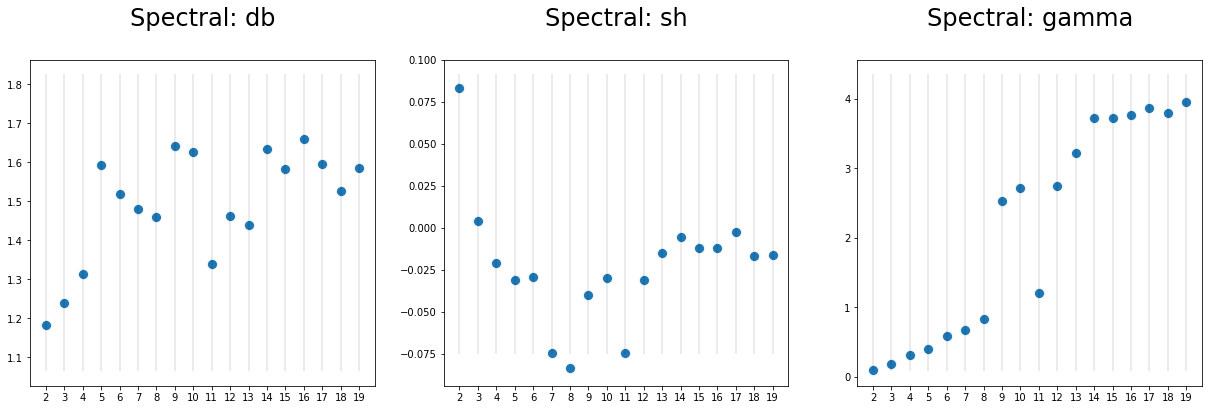

In [142]:
fig = plt.figure()
for i, key in enumerate(audit_spectral.keys()):
    plt.subplot(1,3,i+1)
    sns.scatterplot(np.arange(2,20), audit_spectral[key], s=100)
    plt.xticks(np.arange(2,20))
    plt.vlines(np.arange(2,20),np.min(audit_spectral[key])*0.9,np.max(audit_spectral[key])*1.1, alpha = 0.1)
    plt.title(f'Spectral: {key}\n', size=24)
plt.show()

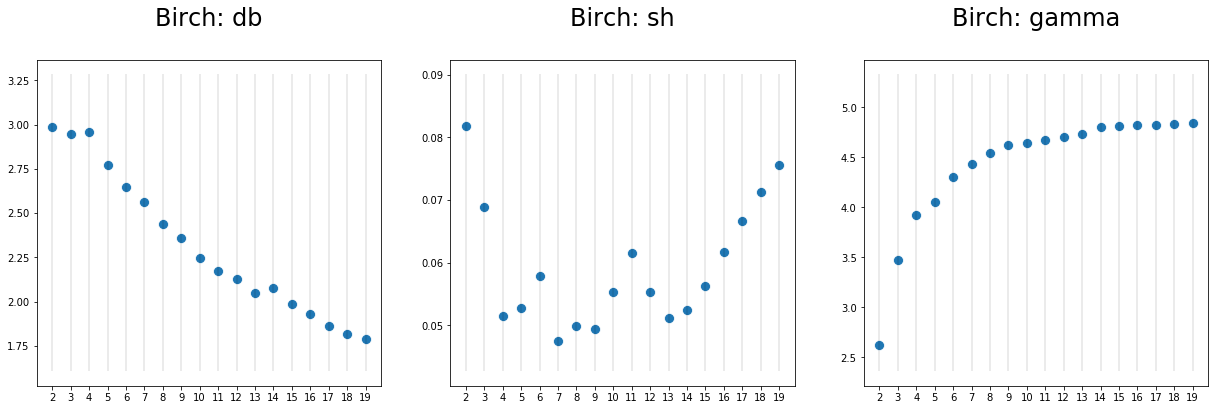

In [143]:
fig = plt.figure()
for i, key in enumerate(audit_birch.keys()):
    plt.subplot(1,3,i+1)
    sns.scatterplot(np.arange(2,20), audit_birch[key], s=100)
    plt.xticks(np.arange(2,20))
    plt.vlines(np.arange(2,20),np.min(audit_birch[key])*0.9,np.max(audit_birch[key])*1.1, alpha = 0.1)
    plt.title(f'Birch: {key}\n', size=24)
plt.show()

In [157]:
tsne = TSNE()
tsne.fit(data_for_clustering_std)

pca = PCA(n_components=2)
pca.fit(data_for_clustering_std)

pass

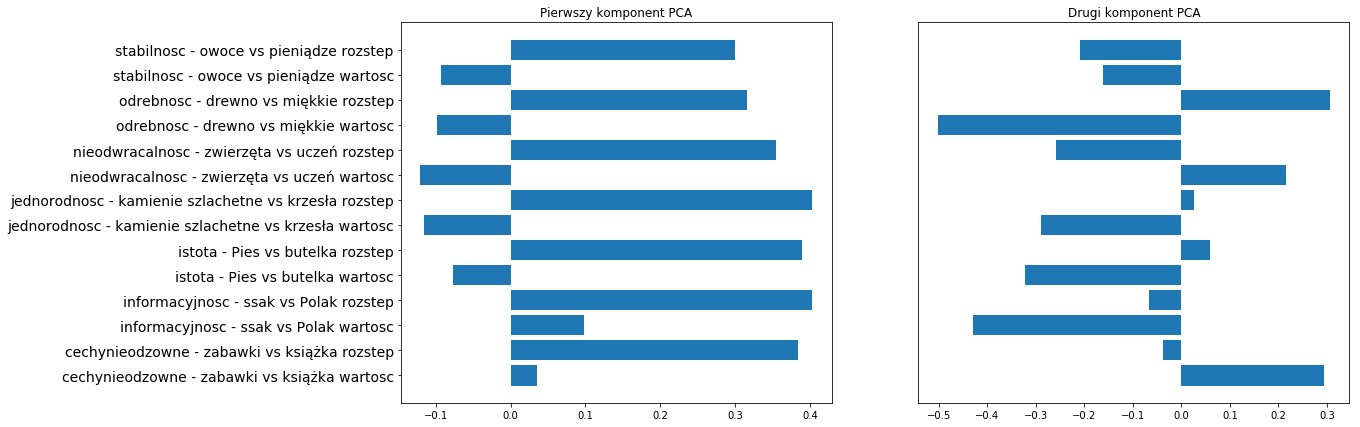

In [158]:
plt.figure(figsize = (17,7))
plt.subplot(1,2,1)
plt.title('Pierwszy komponent PCA')
plt.yticks(size=14)
plt.barh(data_for_clustering.columns, pca.components_[0])
plt.subplot(1,2,2)
plt.title('Drugi komponent PCA')
plt.barh(data_for_clustering.columns, pca.components_[1])
plt.yticks([])
plt.show()

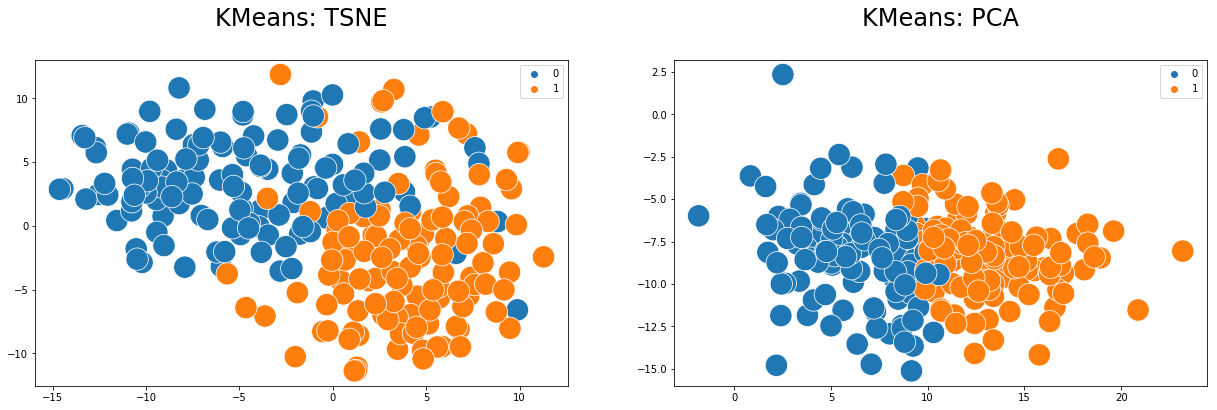

In [162]:
labels = kmean.labels_

plt.subplot(1,2,1)
sns.scatterplot(*tsne.embedding_.T, hue = labels, s=500)
plt.title('KMeans: TSNE\n', size=24)

plt.subplot(1,2,2)
sns.scatterplot(*pca.transform(data_for_clustering).T, hue = labels, s=500)
plt.title('KMeans: PCA\n', size=24)
plt.show()

# xxx = nmf.transform(data_for_clustering)
# sns.scatterplot(xxx[:,0], xxx[:,1], hue = labels, s=1000)
# plt.show()

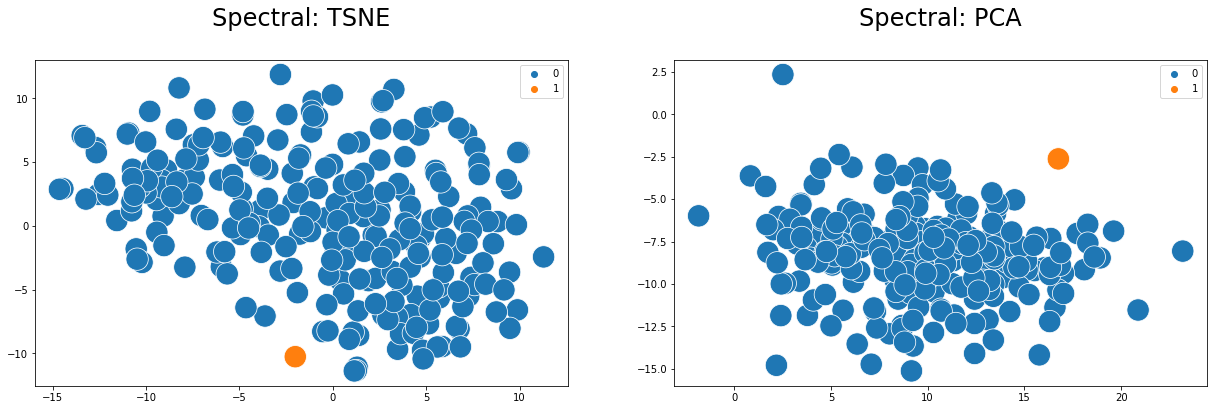

In [163]:
labels = spec.labels_

plt.subplot(1,2,1)
sns.scatterplot(*tsne.embedding_.T, hue = labels, s=500)
plt.title('Spectral: TSNE\n', size=24)

plt.subplot(1,2,2)
sns.scatterplot(*pca.transform(data_for_clustering).T, hue = labels, s=500)
plt.title('Spectral: PCA\n', size=24)
plt.show()

# xxx = nmf.transform(data_for_clustering)
# sns.scatterplot(xxx[:,0], xxx[:,1], hue = labels, s=1000)
# plt.show()

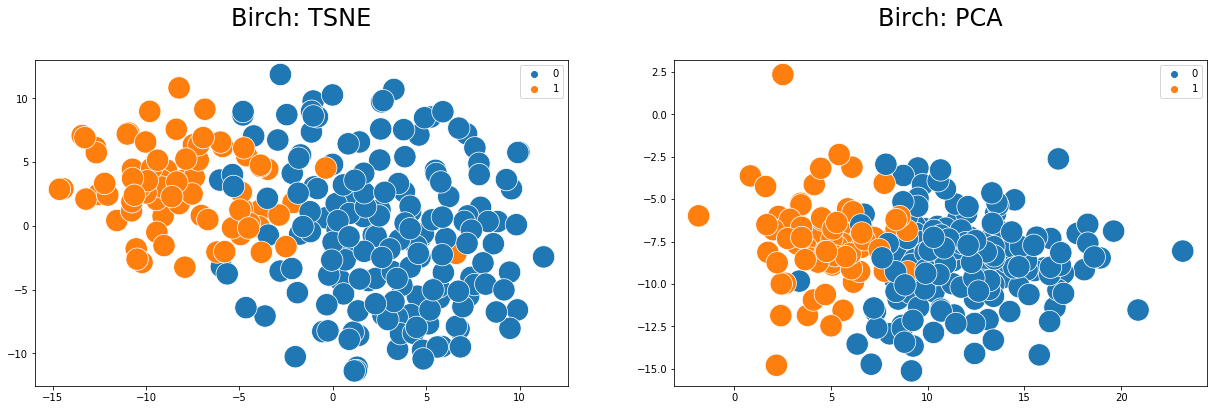

In [164]:
labels = birch.labels_

plt.subplot(1,2,1)
sns.scatterplot(*tsne.embedding_.T, hue = labels, s=500)
plt.title('Birch: TSNE\n', size=24)

plt.subplot(1,2,2)
sns.scatterplot(*pca.transform(data_for_clustering).T, hue = labels, s=500)
plt.title('Birch: PCA\n', size=24)
plt.show()

# xxx = nmf.transform(data_for_clustering)
# sns.scatterplot(xxx[:,0], xxx[:,1], hue = labels, s=1000)
# plt.show()

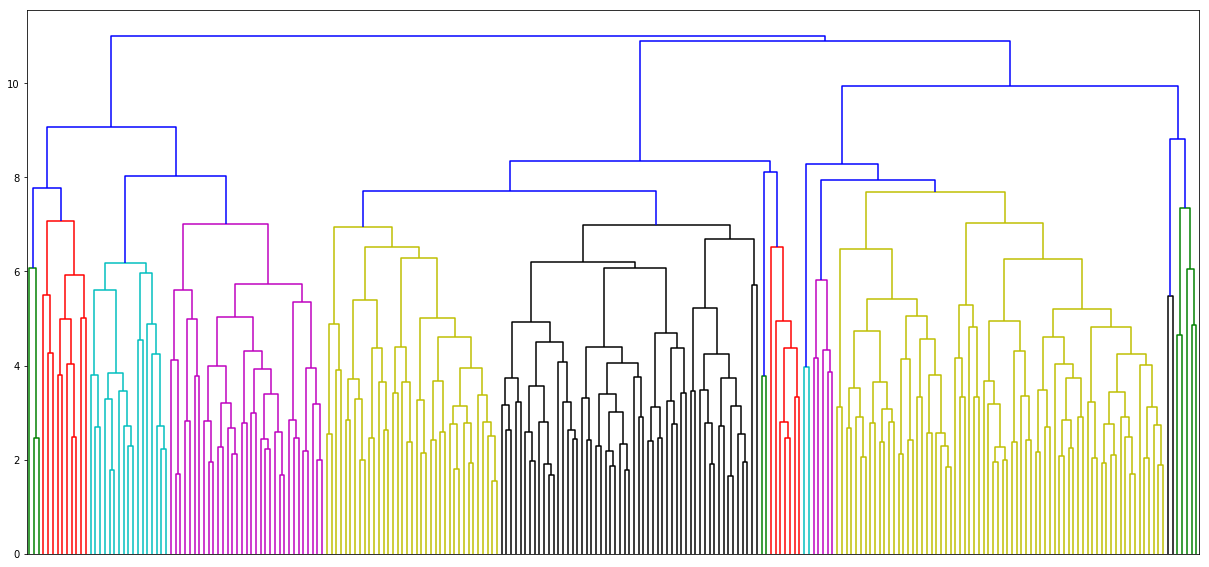

In [155]:
plt.figure(figsize=(21,10))
link = linkage(pdist(data_for_clustering_std), method='complete')
dendrogram(link, )
plt.xticks([])
plt.show()

# Metoda automatycznego znajdowania liczby skupień - DBSCAN

Nie zwróciła żadnych wyników - nie rozpoznała żadnych klastrów

In [149]:
dbscan = DBSCAN()
dbscan.fit(data_for_clustering_std)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

In [150]:
dbscan.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [151]:
results = []
k = 100
for i in range(k):
    kmean = KMeans(n_clusters=2)
    kmean.fit(data_for_clustering_std)
    
    results.append(kmean.labels_)
    


In [152]:
brak_inwencji = []

for i in range(k):
    for j in range(k):
        if i == j:
            continue
        
        if (results[i] == results[j]).mean() >= 0.5:
            brak_inwencji.append((results[i] == results[j]).mean())
        
        else :
            brak_inwencji.append(1 - (results[i] == results[j]).mean())

In [153]:
brak_inwencji = np.array(brak_inwencji)

brak_inwencji.mean()

0.9918132942326491

In [174]:
cluster_0 = data.loc[birch.labels_==0]
cluster_1 = data.loc[birch.labels_==1]

# Różnice w rozkładzie płci

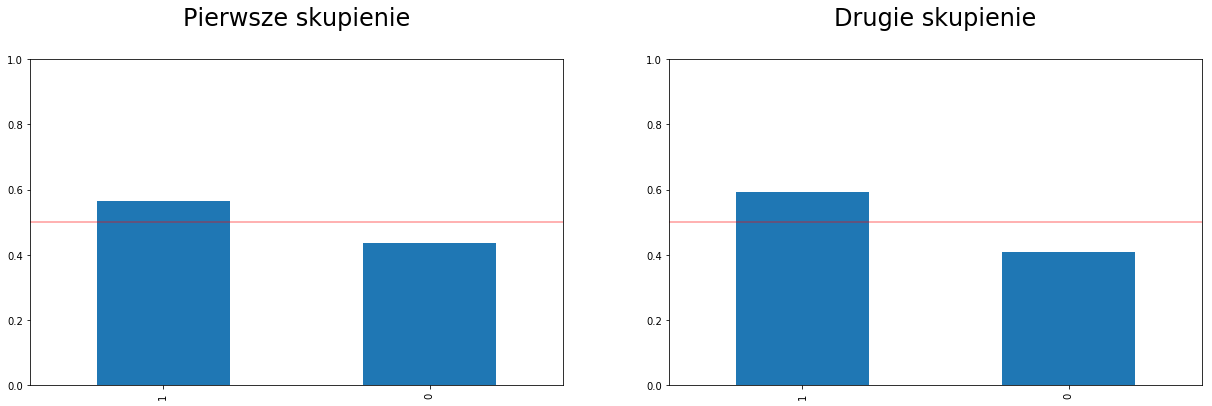

In [205]:
plt.subplot(1,2,1)
a = cluster_0.Płeć.value_counts()/cluster_0.shape[0]
a.plot(kind='bar')
plt.title('Pierwsze skupienie\n', size=24)
plt.ylim(0,1)
plt.hlines(0.5,-1,2,alpha = 0.4, color = 'red')
plt.subplot(1,2,2)
b = cluster_1.Płeć.value_counts()/cluster_1.shape[0]
b.plot(kind='bar')
plt.title('Drugie skupienie\n', size=24)
plt.ylim(0,1)
plt.hlines(0.5,-1,2,alpha = 0.4, color = 'red')
plt.show()

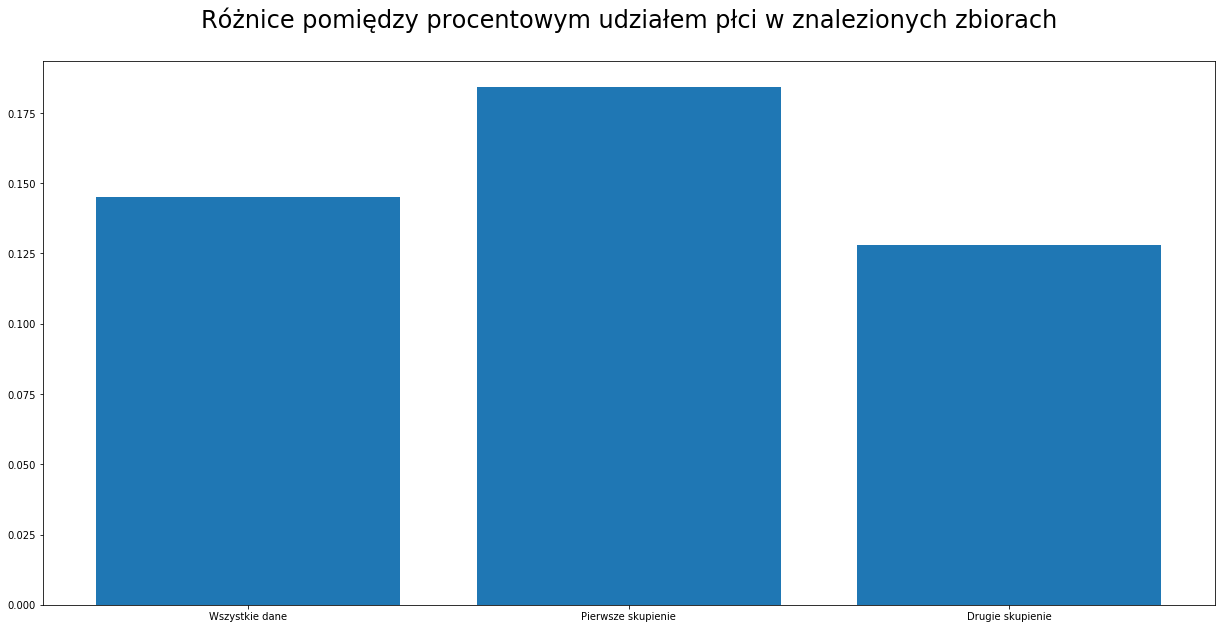

In [218]:
c = data.Płeć.value_counts()/data.shape[0]
plt.figure(figsize=(21,10))
plt.bar(['Wszystkie dane', 'Pierwsze skupienie', 'Drugie skupienie'],[c.loc[1]-c.loc[0], b.loc[1]-b.loc[0], a.loc[1] - a.loc[0]])
plt.title('Różnice pomiędzy procentowym udziałem płci w znalezionych zbiorach\n',size=24)
plt.show()

# Różnice w rozkładzie wieku

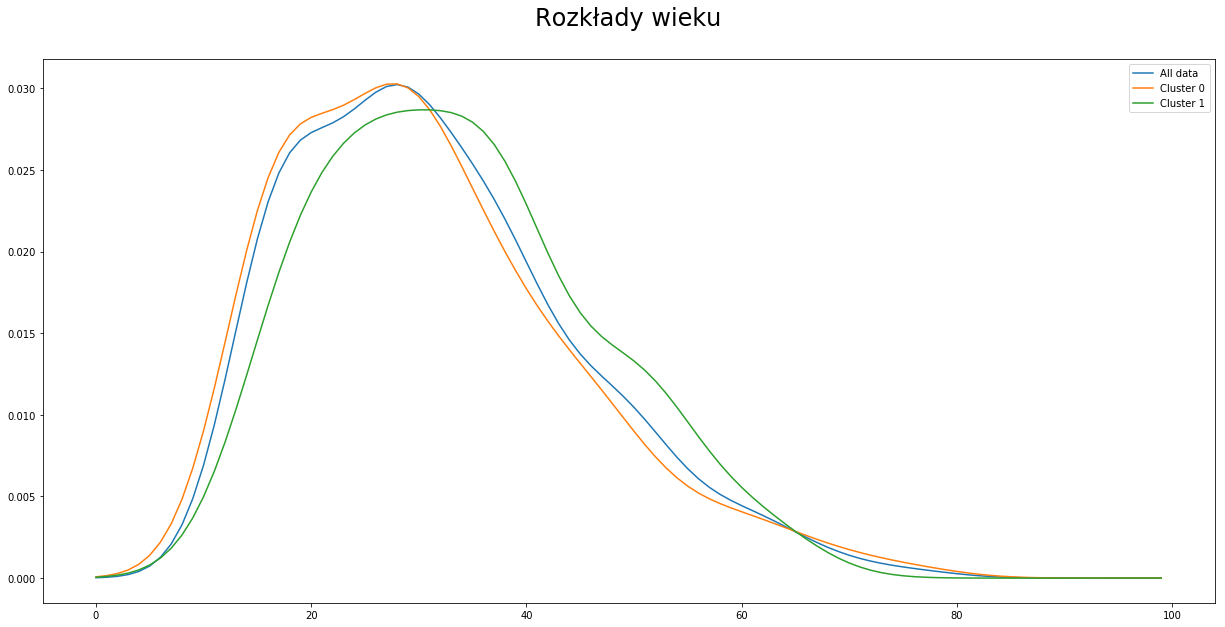

In [219]:
plt.figure(figsize=(21,10))
x = np.arange(0,100)
y = kde.gaussian_kde(data.Wiek)
y0 = kde.gaussian_kde(cluster_0.Wiek)
y1 = kde.gaussian_kde(cluster_1.Wiek)
plt.plot(x,y(x), label = 'All data')
plt.plot(x,y0(x), label = 'Cluster 0')
plt.plot(x,y1(x), label = 'Cluster 1')
plt.title('Rozkłady wieku\n',size=24)
plt.legend()
plt.show()